## MNIST recognition model

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision import datasets
import torchvision.transforms.v2 as tfs
import matplotlib.pyplot as plt

In [76]:
to_tensor_tf = tfs.Compose([tfs.ToImage(), tfs.ToDtype(torch.float32, scale=True)])
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=tfs.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=tfs.ToTensor()
)


c:\Projects\scribble-recognition\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


7


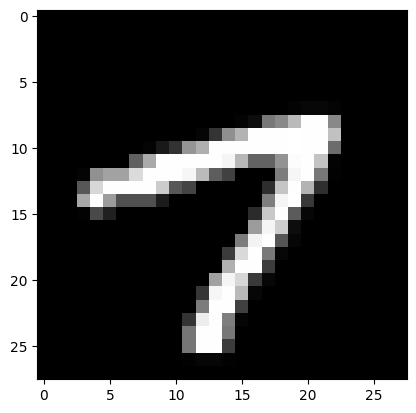

In [77]:
img, label = train_data[101]
print(label)
plt.imshow(img.squeeze(), cmap="gray")

In [78]:
BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [79]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1) # (1, 28, 28) -> (16, 24, 24)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (16, 24, 24) -> (16, 12, 12)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1) # (16, 12, 12) -> (32, 10, 10)
        # pool2 (32, 10, 10) -> (32, 5, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 130) # (800, 130)
        self.fc2 = nn.Linear(130, 10)
    
    def forward(self, x):
        x = self.pool(f.relu(self.conv1(x))) # (1, 28, 28) -> (16, 24, 24) -> (16, 12, 12)
        x = self.pool(f.relu(self.conv2(x))) # (16, 12, 12) -> (32, 10, 10) -> (32, 5, 5)
        x = x.flatten(1) # (32, 5, 5) -> (32, 25)
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [80]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
N_EPOCHS = 2
net = ConvNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [81]:
def train_model():
    for epoch in range(N_EPOCHS):
        epoch_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"epoch: {epoch + 1}, loss: {epoch_loss / len(train_loader)}")


In [82]:
net.train()
train_model()

epoch: 1, loss: 0.16123930739026013
epoch: 2, loss: 0.04731061641247361


In [83]:
MODELS_PATH = "models"
torch.save(net.state_dict(), f"{MODELS_PATH}/cnn.pt")

In [84]:
model = ConvNet()
model.load_state_dict(torch.load(f"{MODELS_PATH}/cnn.pt", weights_only=True))

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
        inputs, true = data
        outputs = model(inputs)
        _, pred = torch.max(outputs, dim=1)
        correct += (pred == true).sum().item()
        total += len(true)
print(f"Accuracy: {(correct / total * 100):.2f}") # 98.74 (120, 10) linear2

Accuracy: 98.61


In [ ]:
def predict(data):
    model = ConvNet()
    model.eval()
    output = model(data)
    _, prediction = torch.max(output, dim=1)
    return prediction